# Memory Recording Application 


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
sns.set(font="Helvetica")

import re
import math
import os

from datetime import datetime, timedelta
from dateutil import parser

In [2]:
DEVICE_SHORT_NAME = {
    'NOIR i2': 'QMobile i2',
    'samsung SM-A510F': 'Samsung A5',
    'samsung SM-G920F': 'Samsung S6',
    'HONOR PRA-LA1': 'Honor 8 Lite',
    'samsung SM-G955U': 'Samsung S8+',
    'samsung SM-G960F': 'Samsung S9',
    'samsung SM-G950F': 'Samsung S8',
    'xiaomi Redmi Note 7': 'Redmi Note 7',
    'xiaomi Redmi Note 7': 'Redmi Note 7',
    'Huawei RNE-L21': 'Mate 10 Lite',
    'Redmi Redmi Note 9S': 'Redmi Note 9S',
    'vivo vivo 1804': 'Vivo V11 Pro',
    'OnePlus ONEPLUS A5000': 'OnePlus 5',
    'OnePlus ONEPLUS A3003': 'OnePlus 3T',
    'OnePlus ONEPLUS A6003': 'OnePlus 6',
    'Itel itel L5002P': 'Itel L5002P'
}

In [3]:
!wget https://www.dropbox.com/s/7cemwtfprkft42r/AppResults.zip
!unzip AppResults.zip

--2021-07-01 20:28:43--  https://www.dropbox.com/s/7cemwtfprkft42r/AppResults.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7cemwtfprkft42r/AppResults.zip [following]
--2021-07-01 20:28:44--  https://www.dropbox.com/s/raw/7cemwtfprkft42r/AppResults.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc490aec452ebde874f58fe832d7.dl.dropboxusercontent.com/cd/0/inline/BRd8Px8iIY8Dx4jA64B7JLybU8ySPNlWrvBnQ265iIMvpRPL5Pt9SZtFLZxKzoo5IpAvIRC-vzcL3ckko1LC7UKXj0gA1YQ8UB8LGt2WcxO5Y2bQr5tLyYh0ylRwPUVSwsBCo7lLzlmGS4G95M-3Ua2v/file# [following]
--2021-07-01 20:28:44--  https://uc490aec452ebde874f58fe832d7.dl.dropboxusercontent.com/cd/0/inline/BRd8Px8iIY8Dx4jA64B7JLybU8ySPNlWrvBnQ265iIMvpRPL5Pt9SZtFLZxKzoo5IpAvIRC-vzcL3ckko

In [4]:
"""PARSE CONFIG. FILES"""

def get_config(log_file_name):
    config_file_name = 'configs/Configuration_' + log_file_name
    if not os.path.exists(config_file_name):
        raise Exception(f'Config file not found for {log_file_name}')
    else:
        config_dict = {}
        with open(config_file_name) as f:
            for i in range(7):
                line = f.readline().strip().split(': ')
                config_dict[line[0]] = line[1]
        return config_dict
# get_config('dcaea37ef9b78bee_samsungSM-A510F_signalsLogger.txt')

In [5]:
def get_df(filename, is_itel=False):
  
  '''Parses the log file and returns its DataFrame'''

  data = []
  with open(filename, "r") as f:
    data = f.readlines()
  result = []
  start_time = 0
  for each_entry in data:
    entry = re.split(r'\s+', each_entry.strip())
    res = {}
    res['time'] = start_time
    start_time += 1
    res['apps'] = entry[-1]
    res['memory'] = entry[-2]
    res['time_string'] = (' '.join(entry[:3]) if '-' in entry[0] else ' '.join(entry[:5])) if not is_itel else ' '.join(entry[:4])
    result.append(res)
  df = pd.DataFrame.from_records(result)
  return df

In [6]:
"""ZIP DEVICE LOGS AND CONFIG TOGETHER"""

logs = os.listdir('signals')
configs = os.listdir('configs')
results = []
for log in logs:
    config = get_config(log)
    device_result = {
        'file_name': log,
        'df': get_df(f'signals/{log}', is_itel=(config['Brand'] == 'Itel')),
        'config': config
    }
    results.append(device_result)

In [7]:
"""Sort results based on device RAM"""

mem_sorted_results = sorted(results, key=lambda result: int(result['config']['Total Memory']))

In [8]:
"""Print the dataset table"""

for result in mem_sorted_results:
    print('{}\t{}\t{}'.format(result['config']['Brand'], result['config']['Model'], result['config']['Total Memory']))

NOIR	i2	1024
samsung	SM-A510F	1843
Itel	itel L5002P	1919
samsung	SM-G920F	2682
HONOR	PRA-LA1	2786
samsung	SM-G955U	3372
samsung	SM-G960F	3611
samsung	SM-G950F	3679
xiaomi	Redmi Note 7	3734
xiaomi	Redmi Note 7	3734
Huawei	RNE-L21	3788
Redmi	Redmi Note 9S	5582
vivo	vivo 1804	5698
OnePlus	ONEPLUS A5000	5711
OnePlus	ONEPLUS A3003	5738
OnePlus	ONEPLUS A6003	7636


In [9]:
'''Helper functions to parse the time string in logs'''

def parse_comma_time_string(og_string):
    time_list = re.split(r'\s+', og_string.strip())
    if len(time_list) != 5:
        print('error:', og_string, time_list)
        raise Exception(f'Couldn\'t parse \'{og_string}\'; [time_list: \'{time_list}\']')
    else:
        time_list[-2] = time_list[-2] if len(time_list[-2]) >= 8 else f'0{time_list[-2]}'
        formatted_string = ' '.join(time_list)
        return datetime.strptime(formatted_string, '%b %d, %Y %I:%M:%S %p')

def parse_dash_time_string(og_string):
    time_list = re.split(r'\s+', og_string.strip())
    if len(time_list) != 3:
        print('error:', og_string, time_list)
        raise Exception(f'Couldn\'t parse \'{og_string}\'; [time_list: \'{time_list}\']')
    else:
        time_list[-2] = time_list[-2] if len(time_list[-2]) >= 8 else f'0{time_list[-2]}'
        formatted_string = ' '.join(time_list)
        return datetime.strptime(formatted_string, '%d-%b-%Y %I:%M:%S %p')

def parse_no_comma_time_string(og_string):
    time_list = re.split(r'\s+', og_string.strip())
    if len(time_list) != 5:
        print('error:', og_string, time_list)
        raise Exception(f'Couldn\'t parse \'{og_string}\'; [time_list: \'{time_list}\']')
    else:
        time_list[-2] = time_list[-2] if len(time_list[-2]) >= 8 else f'0{time_list[-2]}'
        time_list[-1] = time_list[-1].upper()
        formatted_string = ' '.join(time_list)
        return datetime.strptime(formatted_string, '%d %b %Y %I:%M:%S %p')

def parse_itel_time_string(og_string):
    time_list = re.split(r'\s+', og_string.strip())
    if len(time_list) != 4:
        print('error:', og_string, time_list)
        raise Exception(f'Couldn\'t parse \'{og_string}\'; [time_list: \'{time_list}\']')
    else:
        time_list[-1] = time_list[-1] if len(time_list[-1]) >= 8 else f'0{time_list[-1]}'
        formatted_string = ' '.join(time_list)
        return datetime.strptime(formatted_string, '%b %d, %Y %H:%M:%S')
    
def parse_time(og_string, is_itel):
    if is_itel:
        return parse_itel_time_string(og_string)
    elif ',' in og_string:
        return parse_comma_time_string(og_string)
    elif '-' in og_string:
        return parse_dash_time_string(og_string)
    else:
        return parse_no_comma_time_string(og_string)

In [10]:
'''Get available memories recorded at a particular state transition'''

def get_only_mems_at_state(df, state):
    indexes = df[df['memory']==state].index
    mems = []
    for i in indexes:
        curr = int(i)+1
        if df.loc[curr]['apps'] == 'Pressure':
            curr -= 2
        if df.loc[curr]['apps'] != 'Pressure':
            curr_mem = int(df.loc[curr]['memory'])
            mems.append(curr_mem)

    return mems

In [11]:
'''Helper function to be used to in next cell'''

def get_time_to_add(s1, s2, prev_timestamp, is_itel):

    s1_timestamp = parse_time(s1, is_itel).timestamp()
    s1_timestamp = s1_timestamp if s1_timestamp > prev_timestamp else prev_timestamp

    s2_timestamp = parse_time(s2, is_itel).timestamp()
    
    diff = s2_timestamp - s1_timestamp
    
    if diff > 3600:
        diff = 0
        s2_timestamp = s1_timestamp

    return (diff if diff > 0 else 0), s2_timestamp

In [12]:
'''Get estimated duration below and within a particular state'''

def get_mems_below_state(df, state, is_itel):
    if state == 'Critical':
        indexes = df.loc[(df['memory'] == 'Critical')].index
    elif state == 'Low':
        indexes = df.loc[(df['memory'] == 'Critical') | (df['memory'] == 'Low')].index
    elif state == 'Moderate':
        indexes = df.loc[(df['memory'] == 'Critical') | (df['memory'] == 'Low') | (df['memory'] == 'Moderate')].index
    
    # indexes = df[df['apps']=='Pressure'].index
    short_df = df.loc[df['apps'] != 'Pressure']
    mems = []
    time_in_state = 0
    prev = 0
    times = []
    for i in indexes:
        start_time = df.loc[i]['time_string']
        curr = int(i)+1
        if df.loc[curr]['apps'] == 'Pressure':
            curr -= 2
        if df.loc[curr]['apps'] != 'Pressure':
            curr_mem = int(df.loc[curr]['memory'])
            mems.append(curr_mem)

            temp_times = short_df.loc[curr:, ['time_string', 'memory']]
            temp_times['memory'] = temp_times['memory'].astype('int32', copy=True)
            # print('........................')
            end_times = temp_times.loc[temp_times['memory'] > curr_mem]
            # print('============================')
            if len(end_times) > 0:

                end_time = end_times['time_string'].iloc[0]
                time_to_add, parsed_end_time = get_time_to_add(start_time, end_time, prev, is_itel)
                time_in_state += time_to_add

                times.append((start_time, end_time, time_to_add))

                prev = max(parsed_end_time, prev)

    return mems, time_in_state, times

In [13]:
'''Zip the mem state frequency, distribution and duration in the results'''

for result in mem_sorted_results:
    result['total_hours'] = len(result['df'].time_string.unique())/(60*60)

    mems = get_only_mems_at_state(result['df'], 'Moderate')
    _, time_in_and_below_state, _ = get_mems_below_state(result['df'], 'Moderate', result['config']['Brand'] == 'Itel')
    result['moderate_mem'] = {
        'num_of_signals': len(result['df'][result['df']['memory'] == "Moderate"]),
        'mem': mems,
        'times': time_in_and_below_state
    }

    mems = get_only_mems_at_state(result['df'], 'Low')
    _, time_in_and_below_state, _ = get_mems_below_state(result['df'], 'Low', result['config']['Brand'] == 'Itel')
    result['low_mem'] = {
        'num_of_signals': len(result['df'][result['df']['memory'] == "Low"]),
        'mem': mems,
        'times': time_in_and_below_state
    }

    mems = get_only_mems_at_state(result['df'], 'Critical')
    _, time_in_and_below_state, _ = get_mems_below_state(result['df'], 'Critical', result['config']['Brand'] == 'Itel')
    result['critical_mem'] = {
        'num_of_signals': len(result['df'][result['df']['memory'] == "Critical"]),
        'mem': mems,
        'times': time_in_and_below_state
    }

    result['pure_df'] = result['df'].drop_duplicates(subset=['time_string'])

    print('done,', end=' ')

done, done, done, done, done, done, done, done, done, done, done, done, done, done, done, done, 

In [14]:
'''Makes a CSV for the mem state frequency and duration results'''

with open('duration_and_freq_sheet.csv', 'w') as file:

    # write headers
    # file.write('Device Name\tDuration (hrs)\tTotal Memory (MB)\tMean Available Mem (MB)\n')

    for result in mem_sorted_results:
        
        # write device name
        file.write(DEVICE_SHORT_NAME[result['config']['Brand'] + ' ' + result['config']['Model']] + '\t')

        # write duration and total mem
        file.write(f"{result['config']['Total Memory']}\t{result['total_hours']}\t")

        # write no of signals info
        file.write(f"{result['moderate_mem']['num_of_signals']}\t{result['low_mem']['num_of_signals']}\t{result['critical_mem']['num_of_signals']}")

        # write frequency of signals info
        file.write(f"\t{(result['moderate_mem']['num_of_signals'])/(result['total_hours'])}\t{(result['low_mem']['num_of_signals'])/(result['total_hours'])}\t{(result['critical_mem']['num_of_signals'])/(result['total_hours'])}")

        # write duration spent in mem states
        file.write(f"\t{result['moderate_mem']['times']/3600}\t{result['low_mem']['times']/3600}\t{result['critical_mem']['times']/3600}")

        # percentage duration spent in mem states
        file.write(f"\t{((result['moderate_mem']['times']/3600)/result['total_hours'])*100}\t{((result['low_mem']['times']/3600)/result['total_hours'])*100}\t{((result['critical_mem']['times']/3600)/result['total_hours'])*100}")
        
        # go to next line
        file.writelines(f"\n")

In [15]:
'''Makes a CSV for the distribution results'''

with open('distribution_sheet.csv', 'w') as file:

    # write headers
    # file.write('Device Name\tDuration (hrs)\tTotal Memory (MB)\tMean Available Mem (MB)\n')

    for result in mem_sorted_results:
        
        # write device name
        file.write(DEVICE_SHORT_NAME[result['config']['Brand'] + ' ' + result['config']['Model']] + '\t')

        # write duration and total mem
        file.write(f"{result['config']['Total Memory']}\t{result['total_hours']}\t")

        # write available mem info
        memory_data = result['pure_df'].loc[result['pure_df']['apps'] != 'Pressure']['memory'].astype('int32')
        file.write(f"{np.mean(memory_data)}\t{np.std(memory_data)}\t{np.min(memory_data)}\t{np.median(memory_data)}\t{np.max(memory_data)}\t")

        # write moderate mem state info
        file.write(f"{result['moderate_mem']['num_of_signals']}\t{(result['moderate_mem']['num_of_signals'])/(result['total_hours'])}")
        if (len(result['moderate_mem']['mem']) > 0):
            file.write(f"\t{np.average(result['moderate_mem']['mem'])}\t{np.std(result['moderate_mem']['mem'])}\t{np.min(result['moderate_mem']['mem'])}\t{np.median(result['moderate_mem']['mem'])}\t{np.max(result['moderate_mem']['mem'])}")
        else:
            file.write(f"\t-\t-\t-\t-\t-")

        # write low mem state info
        file.write(f"\t{result['low_mem']['num_of_signals']}\t{(result['low_mem']['num_of_signals'])/(result['total_hours'])}")
        if (len(result['low_mem']['mem']) > 0):
            file.write(f"\t{np.average(result['low_mem']['mem'])}\t{np.std(result['low_mem']['mem'])}\t{np.min(result['low_mem']['mem'])}\t{np.median(result['low_mem']['mem'])}\t{np.max(result['low_mem']['mem'])}")
        else:
            file.write(f"\t-\t-\t-\t-\t-")

        # write critical mem state info
        file.write(f"\t{result['critical_mem']['num_of_signals']}\t{(result['critical_mem']['num_of_signals'])/(result['total_hours'])}")
        if (len(result['critical_mem']['mem']) > 0):
            file.write(f"\t{np.average(result['critical_mem']['mem'])}\t{np.std(result['critical_mem']['mem'])}\t{np.min(result['critical_mem']['mem'])}\t{np.median(result['critical_mem']['mem'])}\t{np.max(result['critical_mem']['mem'])}\n")
        else:
            file.writelines(f"\t-\t-\t-\t-\t-\n")

In [16]:
def get_device_name(result, change_redmi_name):
    to_return = DEVICE_SHORT_NAME[result['config']['Brand'] + ' ' + result['config']['Model']]
    if to_return == 'Redmi Note 7' and change_redmi_name:
        to_return = ' Redmi Note 7 '
    return to_return

In [17]:
def make_estimated_lt_duration_df(results):

    # df with x axis as phones, y axis as the duration spent, and the hue is the mem state
    rows = []
    change_redmi_name = False
    for result in results:
        rows.append([get_device_name(result, change_redmi_name), '<= Moderate', (result['moderate_mem']['times']/(result['total_hours']*60*60))*100])
        rows.append([get_device_name(result, change_redmi_name), '<= Low', (result['low_mem']['times']/(result['total_hours']*60*60))*100])
        rows.append([get_device_name(result, change_redmi_name), '<= Critical', (result['critical_mem']['times']/(result['total_hours']*60*60))*100])
        if get_device_name(result, change_redmi_name) == 'Redmi Note 7':
            change_redmi_name = True

    return pd.DataFrame(rows, columns=['Device Name', 'Mem. State', '%age Duration'])

In [18]:
def make_estimated_duration_df(results):

    # df with x axis as phones, y axis as the duration spent, and the hue is the mem state
    rows = []
    change_redmi_name = False
    for result in results:
        c = result['critical_mem']['times']
        l = result['low_mem']['times']- c
        m = result['moderate_mem']['times'] - l
        rows.append([get_device_name(result, change_redmi_name), 'Moderate', (m/(result['total_hours']*60*60))*100])
        rows.append([get_device_name(result, change_redmi_name), 'Low', (l/(result['total_hours']*60*60))*100])
        rows.append([get_device_name(result, change_redmi_name), 'Critical', (c/(result['total_hours']*60*60))*100])
        if get_device_name(result, change_redmi_name) == 'Redmi Note 7':
            change_redmi_name = True

    return pd.DataFrame(rows, columns=['Device Name', 'Mem. State', '%age Duration'])

make_estimated_duration_df(mem_sorted_results).groupby(['Device Name']).sum().sort_values(['%age Duration'])

,%age Duration
Device Name,
QMobile i2,0.000000
Redmi Note 9S,0.000000
Samsung A5,0.000000
OnePlus 6,0.003420
OnePlus 5,0.003748
OnePlus 3T,0.015637
Honor 8 Lite,0.044571
Samsung S6,0.086378
Samsung S8,0.191983


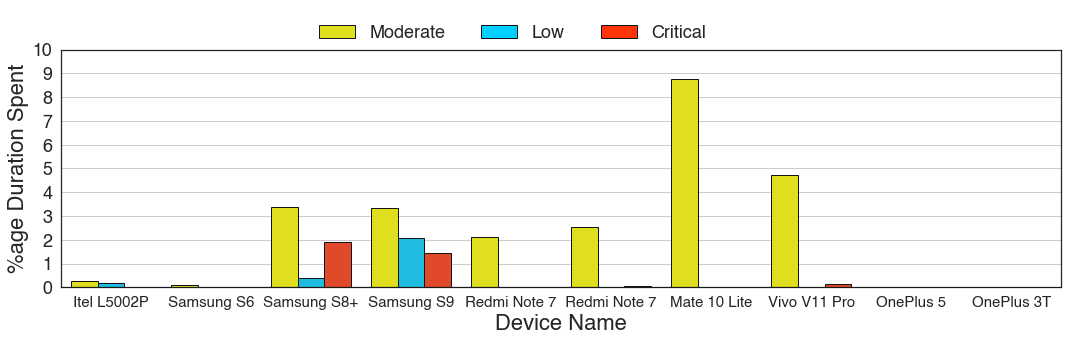

In [19]:
def plot_frames_dropped(ax, df_to_plot, order):

    sns.barplot(ax=ax, edgecolor='#141414', linewidth=1, data=df_to_plot, x='Device Name', y='%age Duration', hue='Mem. State', order=order, hue_order=['Moderate', 'Low', 'Critical'], palette={'Moderate': '#FFFF00', 'Low': '#00D0FF', 'Critical': '#ff350a'}, capsize=.05, errwidth=1.75, errcolor='#141414')

    ax.set_xlabel('Device Name', fontsize=22, fontname='Helvetica')
    ax.set_ylabel('%age Duration Spent', fontsize=22, fontname='Helvetica')

    p1 = mpatches.Patch(color='#DFDF1E', label='Moderate', ec='#141414', lw=1)
    p2 = mpatches.Patch(color='#00D0FF', label='Low', ec='#141414', lw=1)
    p3 = mpatches.Patch(color='#ff350a', label='Critical', ec='#141414', lw=1)

    ax.legend(handles=[p1,p2,p3], bbox_to_anchor=(0.24, 1.18),  loc=2, fontsize=18, borderaxespad=0., borderpad=1, frameon=False, facecolor='white', ncol=3) #, title='Memory Status', title_fontsize=13)

    ax.set_yticks(range(0,10+1,1))
    ax.set_yticklabels(range(0,10+1,1), rotation=0, fontsize=18, fontname='Helvetica')
    ax.yaxis.set_tick_params(direction='out', length=5, width=1)

    ax.set_xticks(range(0, len(set(df_to_plot['Device Name']))))
    # print(set(df_to_plot['Device Name']))
    ax.set_xticklabels(order, rotation=0, fontsize=15, fontname='Helvetica')
    ax.xaxis.set_tick_params(direction='out', length=5, width=1)

    ax.grid(axis='y')
    ax.set_facecolor('white')
    # ax.set_edgecolor('k')
    # ax.get_legend().remove()
    ax.spines["bottom"].set_visible(True)
    ax.spines['bottom'].set_color('k')
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)

results_to_plot2 = [result for result in mem_sorted_results if result['total_hours'] > 15]
results_to_plot2 = results_to_plot2[:6] + [mem_sorted_results[10]] + results_to_plot2[6:-1]
order = [get_device_name(result, False) for result in results_to_plot2]
order[5] = ' ' + order[5] + ' '

df_to_plot = make_estimated_duration_df(results_to_plot2)

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(1, 1, facecolor='white', edgecolor='k', figsize=(15,5))

plot_frames_dropped(ax, df_to_plot, order)

plt.tight_layout()

plt.savefig(f"./survey_duration_results2.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.05)

# ax = sns.barplot(data=df_60fps, x='Resolution', y='%age Frames Dropped', hue='Mem. State')

In [20]:
def make_frequency_df(results):

    # df with x axis as phones, y axis as the duration spent, and the hue is the mem state
    rows = []
    change_redmi_name = False
    for result in results:
        rows.append([get_device_name(result, change_redmi_name), 'Moderate', result['moderate_mem']['num_of_signals']/result['total_hours']])
        rows.append([get_device_name(result, change_redmi_name), 'Low', result['low_mem']['num_of_signals']/result['total_hours']])
        rows.append([get_device_name(result, change_redmi_name), 'Critical', result['critical_mem']['num_of_signals']/result['total_hours']])
        if get_device_name(result, change_redmi_name) == 'Redmi Note 7':
            change_redmi_name = True

    return pd.DataFrame(rows, columns=['Device Name', 'Mem. State', 'Frequency of Signals'])

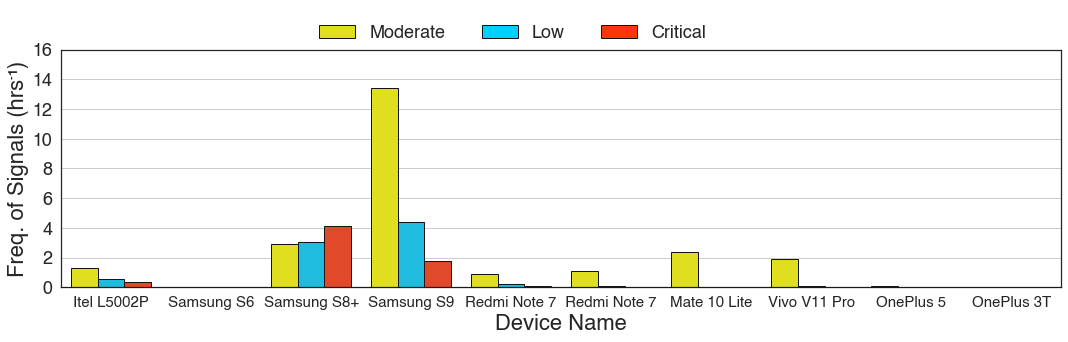

In [21]:
def plot_frames_dropped(ax, df_to_plot, order):

    sns.barplot(ax=ax, edgecolor='#141414', linewidth=1, data=df_to_plot, x='Device Name', y='Frequency of Signals', hue='Mem. State', order=order, hue_order=['Moderate', 'Low', 'Critical'], palette={'Moderate': '#FFFF00', 'Low': '#00D0FF', 'Critical': '#ff350a'}, capsize=.05, errwidth=1.75, errcolor='#141414')

    ax.set_xlabel('Device Name', fontsize=22, fontname='Helvetica')
    ax.set_ylabel('Freq. of Signals (hrs⁻¹)', fontsize=22, fontname='Helvetica')

    p1 = mpatches.Patch(color='#DFDF1E', label='Moderate', ec='#141414', lw=1)
    p2 = mpatches.Patch(color='#00D0FF', label='Low', ec='#141414', lw=1)
    p3 = mpatches.Patch(color='#ff350a', label='Critical', ec='#141414', lw=1)

    ax.legend(handles=[p1,p2,p3], bbox_to_anchor=(0.24, 1.18),  loc=2, fontsize=18, borderaxespad=0., borderpad=1, frameon=False, facecolor='white', ncol=3) #, title='Memory Status', title_fontsize=13)

    ax.set_yticks(range(0,16+1,2))
    ax.set_yticklabels(range(0,16+1,2), rotation=0, fontsize=18, fontname='Helvetica')
    ax.yaxis.set_tick_params(direction='out', length=5, width=1)

    ax.set_xticks(range(0, len(set(df_to_plot['Device Name']))))
    # print(set(df_to_plot['Device Name']))
    ax.set_xticklabels(order, rotation=0, fontsize=15, fontname='Helvetica')
    ax.xaxis.set_tick_params(direction='out', length=5, width=1)

    ax.grid(axis='y')
    ax.set_facecolor('white')
    # ax.set_edgecolor('k')
    # ax.get_legend().remove()
    ax.spines["bottom"].set_visible(True)
    ax.spines['bottom'].set_color('k')
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)

results_to_plot2 = [result for result in mem_sorted_results if result['total_hours'] > 15]
results_to_plot2 = results_to_plot2[:6] + [mem_sorted_results[10]] + results_to_plot2[6:-1]
order = [get_device_name(result, False) for result in results_to_plot2]
order[5] = ' ' + order[5] + ' '

df_to_plot = make_frequency_df(results_to_plot2)

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(1, 1, facecolor='white', edgecolor='k', figsize=(15,5))

plot_frames_dropped(ax, df_to_plot, order)

plt.tight_layout()

plt.savefig(f"./survey_freq_results2.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.05)

# ax = sns.barplot(data=df_60fps, x='Resolution', y='%age Frames Dropped', hue='Mem. State')

In [22]:
def make_availmem_df(results):
    
    change_redmi_name = False
    
    total_df = results[0]['pure_df'].loc[results[0]['pure_df']['apps'] != 'Pressure'].copy()
    total_df['memory'] = total_df['memory'].astype('float64')
    total_mem = float(results[0]['config']['Total Memory'])
    total_df['memory_util'] = ((total_mem - total_df['memory'].astype('float64')) / total_mem) * 100
    total_df['Device Name'] = get_device_name(results[0], change_redmi_name)
    
    for result in results[1:]:
        df = result['pure_df'].loc[result['pure_df']['apps'] != 'Pressure'].copy()
        df['memory'] = df['memory'].astype('float64')
        total_mem = float(result['config']['Total Memory'])
        df['memory_util'] = ((total_mem - df['memory'].astype('float64')) / total_mem) * 100
        df['Device Name'] = get_device_name(result, change_redmi_name)
        total_df = total_df.append(df, ignore_index=True)
        if get_device_name(result, change_redmi_name) == 'Redmi Note 7':
            change_redmi_name = True


    return total_df

In [23]:
results_to_plot = make_availmem_df([result for result in mem_sorted_results if result['total_hours'] > 15])

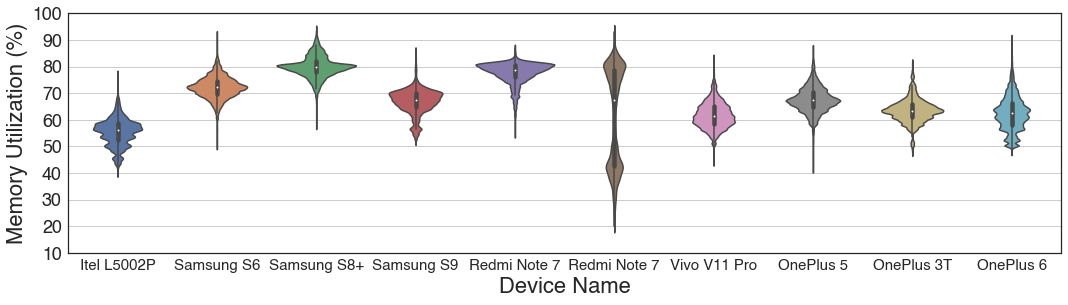

In [24]:
with plt.style.context("seaborn-white"):
    
    fig, ax = plt.subplots(1, 1, facecolor='white', edgecolor='k', figsize=(15,4.4))
    
    sns.violinplot(x="Device Name", y="memory_util",  data=results_to_plot, ax=ax) #, inner=None)
    
    ax.set_xlabel('Device Name', fontsize=22, fontname='Helvetica')
    ax.set_ylabel('Memory Utilization (%)', fontsize=22, fontname='Helvetica')
    
    yticks = range(10,100+1,10)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, rotation=0, fontsize=18, fontname='Helvetica')
    ax.yaxis.set_tick_params(direction='inout', length=5, width=1)

#     ax.set_xticks(range(0, 9))
    ax.set_xticklabels(
        ['Itel L5002P', 'Samsung S6', 'Samsung S8+', 'Samsung S9', 'Redmi Note 7', ' Redmi Note 7 ',
         'Vivo V11 Pro', 'OnePlus 5', 'OnePlus 3T', 'OnePlus 6'], rotation=0, fontsize=15, fontname='Helvetica')
    ax.xaxis.set_tick_params(direction='inout', length=5, width=1)

    plt.grid(axis='y')
    plt.tight_layout()

    plt.savefig(f"./survey_availmem_violin.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.05)

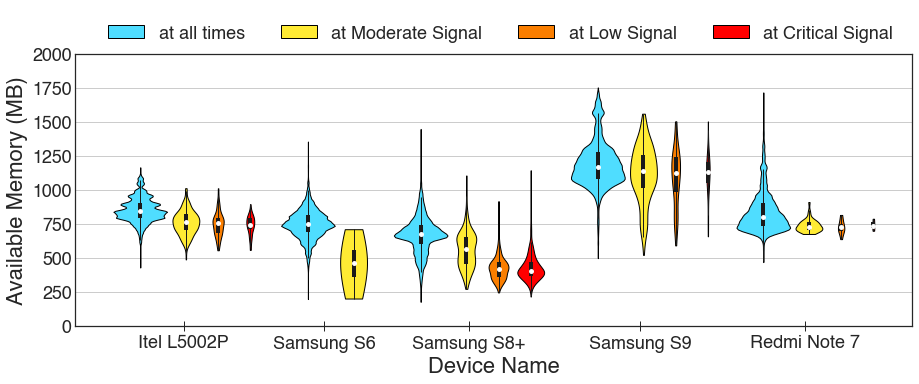

In [25]:
'''Makes a violin plot for the mem distribution in the four devices with the least RAM from among the devices that had more than 15 hours of logged information'''

results_to_plot = [result for result in mem_sorted_results if result['total_hours'] > 15][:5]

def adjacent_values(vals, q1, q3):

    vals = sorted(vals)

    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels, positions):

    ax.xaxis.set_tick_params(direction='inout', length=10, width=1)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=0, fontsize=18, fontname='Helvetica')
    ax.set_xlabel('Device Name', fontsize=22, fontname='Helvetica')
    
    ax.set_ylabel('Available Memory (MB)', fontsize=22, fontname='Helvetica')
    ax.set_ylim(0, 2000)
    ax.set_yticks(list(range(0,2000+1,250)))
    ax.set_yticklabels(list(range(0,2000+1,250)), rotation=0, fontsize=18, fontname='Helvetica')

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

start_ind = 1
space_between_mem_and_states = 0.25/2 + 0.3
space_between_states = 0.3
space_between_devices = 0.5

start_ind = 1
space_between_mem_and_states = 0.25/2 + 0.3
space_between_states = 0.3

ax.set_title('Customized violin plot')

device_count = 0
inds_list = []
labels_list = []
last_plot_ending_x = 0

for result in results_to_plot:

    # create test data
    # result = mem_sorted_results[5]
    memory_data = result['df'].loc[result['df']['apps'] != 'Pressure']['memory'].astype('int32')

    data = [list(memory_data)]

    if len(result['moderate_mem']['mem']) > 0:
        data.append(list(result['moderate_mem']['mem']))
        if len(result['low_mem']['mem']) > 0:
            data.append(list(result['low_mem']['mem']))
            if len(result['critical_mem']['mem']) > 0:
                data.append(list(result['critical_mem']['mem']))

    # set the indices and widths
    # print('states:', (s_i := start_ind + 3*device_count, np.arange(s_i := s_i + space_between_mem_and_states, s_i + space_between_states*3 - 0.1, space_between_states)))

    inds = np.append(s_i := last_plot_ending_x + space_between_devices, np.arange(s_i := s_i + space_between_mem_and_states, s_i + space_between_states*3 - 0.1, space_between_states))[:len(data)]
    
    max_len = max([len(result['moderate_mem']['mem']), len(result['low_mem']['mem']), len(result['critical_mem']['mem'])])
    # print('1:', len(result['moderate_mem']['mem']), len(result['low_mem']['mem']), len(result['critical_mem']['mem']), max_len, sep=',')
    vplot_widths = [
            0.5,
            0.25 * (len(result['moderate_mem']['mem']) / max_len),
            0.25 * (len(result['low_mem']['mem']) / max_len),
            0.25 * (len(result['critical_mem']['mem']) / max_len)
        ]

    # print('vplot_widths:', vplot_widths)

    vplot_widths = vplot_widths[:len(data)]
    # print('inds:', inds)

    last_plot_ending_x = inds[-1] + vplot_widths[-1]/2

    parts = ax.violinplot(
            data, showmeans=False, showmedians=False,
            showextrema=False, positions=inds, widths=vplot_widths)

    for pc in parts['bodies']:
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    parts['bodies'][0].set_facecolor('#4FDDFF') # blue 41D0FF, green 4CE663
    if len(data) >= 2:
        parts['bodies'][1].set_facecolor('#FFEB34')
        if len(data) >= 3:
            parts['bodies'][2].set_facecolor('#FA7E00')
            if len(data) >= 4:
                parts['bodies'][3].set_facecolor('#FF0000')

    quartile1 = []
    medians = []
    quartile3 = []
    for item in data:
        q1, median, q3 = np.percentile(item, [25, 50, 75])
        # print('percentile', q1, median, q3)
        quartile1.append(q1)
        medians.append(median)
        quartile3.append(q3)

    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    # print('whiskers:', whiskers)

    ax.scatter(inds, medians, marker='o', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    
    inds_list.append((inds[0]-vplot_widths[0]/2 + inds[-1]+vplot_widths[-1]/2)/2)
    
    labels_list.append(DEVICE_SHORT_NAME[result['config']['Brand'] + ' ' + result['config']['Model']])

    device_count += 1

# set style for the axes
set_axis_style(ax, labels_list, inds_list)

# p0 = mpatches.Patch(color='#FFFFFF', label='Available Memory')
p1 = mpatches.Patch(color='#4FDDFF', ec='black', label='at all times')
p2 = mpatches.Patch(color='#FFEB34', ec='black', label='at Moderate Signal')
p3 = mpatches.Patch(color='#FA7E00', ec='black', label='at Low Signal')
p4 = mpatches.Patch(color='#FF0000', ec='black', label='at Critical Signal')

ax.legend(handles=[p1,p2,p3, p4], bbox_to_anchor=(0.018, 1.175),
          loc=2, fontsize=18, borderaxespad=0., borderpad=1,
          frameon=False, facecolor='white', ncol=4) #, title='Memory Status', title_fontsize=13)

plt.title('', fontsize=18)

plt.grid(axis='y')

plt.savefig(f"./violinplot_first4.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

plt.show()